In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import animation 
from PIL import Image

import os

from IPython.display import HTML

In [2]:
gpu = torch.cuda.is_available()
device = torch.device("cuda" if gpu else "cpu")

In [3]:
print(gpu, device)

False cpu


# Config

In [107]:
experiment_name = f"convolutional_autoencoder_v7"
model_type = "autoencoder"

num_layers = 4
max_filters = 512
batch_size = 64
image_size = 64
latent_dim = 2048

data_prefix = f""
data_folder = data_prefix + "original_data/"

output_prefix = f"outputs/{experiment_name}"
output_dir = output_prefix + "/generated/"
model_output_path = output_prefix + "/model.pt"
animation_output_path = output_prefix + "/animation.mp4"
loss_output_path = output_prefix + "/loss.jpg"

# Load Model

In [108]:
# Ref: https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb
class ConvolutionalAE(nn.Module):
    def __init__(self, image_channels=3, max_filters=512, num_layers=4, kernel_size=2, stride=2, 
                 padding=0, latent_dim=128, input_image_dimensions=96):
        super(ConvolutionalAE, self).__init__()
        channel_sizes = self.calculate_channel_sizes(image_channels, max_filters, num_layers)
        # Calculate shape of the flattened image
        hidden_dim, image_size = self.get_flattened_size(kernel_size, stride, max_filters, 
                                                         input_image_dimensions, num_layers)

        # Encoder
        encoder_layers = nn.ModuleList()
        for i, channel_size in enumerate(channel_sizes):
            in_channels = channel_size[0]
            out_channels = channel_size[1]
            # Convolutional Layer
            encoder_layers.append(
                nn.Conv2d(
                    in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, 
                    stride=stride, padding=padding, bias=False
                )
            )
            # Batch Norm
            encoder_layers.append(nn.BatchNorm2d(out_channels))
            # ReLU
            encoder_layers.append(nn.ReLU())
        # Flatten Encoder Output
        encoder_layers.append(nn.Flatten())
        # Hidden Dim -> Latent Dim
        encoder_layers.append(nn.Linear(hidden_dim, latent_dim))
        encoder_layers.append(nn.Sigmoid())
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Decoder
        decoder_layers = nn.ModuleList()
        # Latent Dim -> Hidden Dim
        decoder_layers.append(nn.Linear(latent_dim, hidden_dim))
        decoder_layers.append(nn.Sigmoid())
        # Unflatten to a shape of (Channels, Height, Width)
        decoder_layers.append(nn.Unflatten(1, (max_filters, image_size, image_size)))
        for i, channel_size in enumerate(channel_sizes[::-1]):
            in_channels = channel_size[1]
            out_channels = channel_size[0]
            # Add Transposed Convolutional Layer
            decoder_layers.append(
                nn.ConvTranspose2d(
                    in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, 
                    stride=stride, padding=padding, bias=False
                )
            )
            # Batch Norm
            decoder_layers.append(nn.BatchNorm2d(out_channels))
            # ReLU if not final layer
            if i != num_layers - 1:
                decoder_layers.append(nn.ReLU())
            # Sigmoid if final layer
            else:
                decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers) 
        
    def get_flattened_size(self, kernel_size, stride, filters, input_image_dimensions, num_layers):
        x = input_image_dimensions
        for i in range(num_layers):
            x = ((x - kernel_size) // stride) + 1
        return filters * x * x, x
    
    def calculate_channel_sizes(self, image_channels, max_filters, num_layers):
        channel_sizes = [(image_channels, max_filters // np.power(2, num_layers - 1))]
        for i in range(1, num_layers):
            prev = channel_sizes[-1][-1]
            new = prev * 2
            channel_sizes.append((prev, new))
        return channel_sizes
        
    def forward(self, x):
        # Encode
        hidden_state = self.encoder(x)
        # Decode
        reconstructed = self.decoder(hidden_state)
        return reconstructed

In [109]:
# Ref: https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb
class ConvolutionalVAE(nn.Module):
    def __init__(self, image_channels=3, max_filters=512, num_layers=4, kernel_size=2, stride=2, 
                 padding=0, latent_dim=128, input_image_dimensions=96):
        super(ConvolutionalVAE, self).__init__()
        channel_sizes = self.calculate_channel_sizes(image_channels, max_filters, num_layers)
        # Encoder
        encoder_layers = nn.ModuleList()
        for i, channel_size in enumerate(channel_sizes):
            in_channels = channel_size[0]
            out_channels = channel_size[1]
            # Convolutional Layer
            encoder_layers.append(
                nn.Conv2d(
                    in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, 
                    stride=stride, padding=padding, bias=False
                )
            )
            # Batch Norm
            encoder_layers.append(nn.BatchNorm2d(out_channels))
            # ReLU
            encoder_layers.append(nn.ReLU())
        # Flatten Encoder Output
        encoder_layers.append(nn.Flatten())
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Calculate shape of the flattened image
        hidden_dim, image_size = self.get_flattened_size(kernel_size, stride, max_filters, input_image_dimensions)
        
        # Latent Space
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        decoder_layers = nn.ModuleList()
        # Feedforward/Dense Layer to expand our latent dimensions
        decoder_layers.append(nn.Linear(latent_dim, hidden_dim))
        # Unflatten to a shape of (Channels, Height, Width)
        decoder_layers.append(nn.Unflatten(1, (max_filters, image_size, image_size)))
        for i, channel_size in enumerate(channel_sizes[::-1]):
            in_channels = channel_size[1]
            out_channels = channel_size[0]
            # Add Transposed Convolutional Layer
            decoder_layers.append(
                nn.ConvTranspose2d(
                    in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, 
                    stride=stride, padding=padding, bias=False
                )
            )
            # Batch Norm
            decoder_layers.append(nn.BatchNorm2d(out_channels))
            # ReLU if not final layer
            if i != num_layers - 1:
                decoder_layers.append(nn.ReLU())
            # Sigmoid if final layer
            else:
                decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers) 
        
    def get_flattened_size(self, kernel_size, stride, filters, input_image_dimensions):
        x = input_image_dimensions
        for layer in self.encoder:
            if "Conv2d" in str(layer):
                x = ((x - kernel_size) // stride) + 1
        return filters * x * x, x
    
    def calculate_channel_sizes(self, image_channels, max_filters, num_layers):
        channel_sizes = [(image_channels, max_filters // np.power(2, num_layers - 1))]
        for i in range(1, num_layers):
            prev = channel_sizes[-1][-1]
            new = prev * 2
            channel_sizes.append((prev, new))
        return channel_sizes
        
    def forward(self, x):
        # Encode
        hidden_state = self.encoder(x)
        # Reparameterize
        mu = self.fc_mu(hidden_state) 
        log_var = self.fc_log_var(hidden_state)
        z = self.reparameterize(mu, log_var)
        # Decode
        reconstructed = self.decoder(z)
        return reconstructed, mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var.mul(0.5)) # log sqrt(x) = log x^0.5 = 0.5 log x
        epsilon = torch.randn_like(mu)
        z = mu + (epsilon * std)
        return z

In [110]:
if model_type == "autoencoder":
    model = ConvolutionalAE(max_filters=max_filters, num_layers=num_layers, input_image_dimensions=image_size, 
                            latent_dim=latent_dim)
else:
    model = ConvolutionalVAE(max_filters=max_filters, num_layers=num_layers, input_image_dimensions=image_size, 
                             latent_dim=latent_dim)

In [111]:
model.load_state_dict(torch.load(f"outputs/{experiment_name}/model.pt", map_location=device))

<All keys matched successfully>

In [112]:
model.eval()

ConvolutionalAE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=8192, out_features=2048, bias=True)
    (14): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2048, out_features=8192, bias=True)
    (1): Sigmoid()
    (

# Set up Transform

In [113]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(image_size, interpolation=transforms.InterpolationMode.BICUBIC),
])

# Load All Pokemon

In [114]:
def show_image(image, model_output=False):
    if model_output:
        image = image.detach().squeeze(0)
    plt.imshow(image.permute(1, 2, 0).numpy())

In [115]:
def animate(image, axis):
    axis.imshow(image.permute(1, 2, 0).numpy())

In [116]:
def create_animation(frames):
    fig, axis = plt.subplots(1, 1, dpi=80)
    plt.tight_layout()
    plt.close()
    return animation.FuncAnimation(fig=fig, func=animate, frames=frames, fargs=(axis, ), interval=300, repeat=True)

In [117]:
pokemon = {}
background = Image.new("RGBA", (image_size, image_size), (255, 255, 255))
for file in os.listdir(data_folder):
    id_ = file.split('.')[0].split('_')[0].split('-')[0]
    form = '_'.join(file.split('.')[0].split('_')[1:])
    image = Image.open(os.path.join(data_folder, file))
    image = image.resize((image_size, image_size), resample=Image.BICUBIC).convert("RGBA")
    image = Image.alpha_composite(background, image).convert("RGB")
    if id_ not in pokemon:
        pokemon[id_] = {}
    pokemon[id_][form] = transform(image)

In [118]:
def combine(image1, image2, mode, **kwargs):
    image1 = image1.clone()
    image2 = image2.clone()
    if mode == 'add':
        if 'weights' in kwargs:
            weight1, weight2 = kwargs['weights']
        else:
            weight1, weight2 = 1, 1
        return torch.add(torch.mul(image1, weight1), torch.mul(image2, weight2)) / (weight1 + weight2)
    if mode == 'recombine':
        feature_dims = np.random.randint(0, image1.shape[1], kwargs['num_dims'])
        image1[0, feature_dims] = image2[0, feature_dims]
        return image1

In [119]:
image_one = pokemon['150']['base_bw']
image_two = pokemon['006']['base_bw']

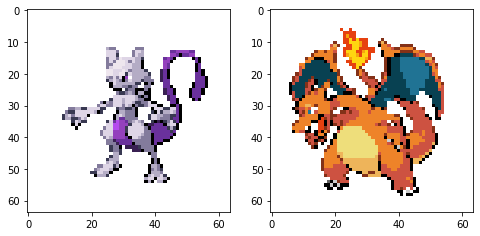

In [120]:
fig=plt.figure(figsize=(8, 8))
fig.add_subplot(1, 2, 1)
show_image(image_one)
fig.add_subplot(1, 2, 2)
show_image(image_two)

## Add

In [121]:
# Get latent representations
if model_type == "autoencoder":
    output_one = model.encoder(image_one.unsqueeze(0)).detach()
    output_two = model.encoder(image_two.unsqueeze(0)).detach()
else:
    _, output_one_mu, output_one_log_var = model(image_one.unsqueeze(0))
    _, output_two_mu, output_two_log_var = model(image_two.unsqueeze(0))
    output_one_mu = output_one_mu.detach()
    output_one_log_var = output_one_log_var.detach()
    output_two_mu = output_two_mu.detach()
    output_two_log_var = output_two_log_var.detach()

In [122]:
# Sample of combining the latent representations
weights = (0.5, 0.5)
if model_type == "autoencoder":
    combined = combine(output_one, output_two, mode='add', weights=weights)
else:
    combined_mu = combine(output_one_mu, output_two_mu, mode='add', weights=weights)
    combined_log_var = combine(output_one_log_var, output_two_log_var, mode='add', weights=weights)
    combined = model.reparameterize(combined_mu, combined_log_var)

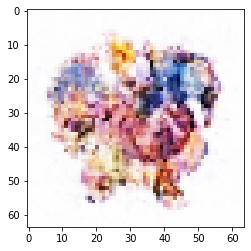

In [123]:
show_image(model.decoder(combined), model_output=True)

In [124]:
# Animation
to_animate = []
for i in np.arange(0.0, 1.0, 0.1):
    if model_type == "autoencoder":
        out = combine(output_one, output_two, mode='add', weights=(i, 1-i))
    else:
        combined_mu = combine(output_one_mu, output_two_mu, mode='add', weights=weights)
        combined_log_var = combine(output_one_log_var, output_two_log_var, mode='add', weights=weights)
        out = model.reparameterize(combined_mu, combined_log_var)
    out = model.decoder(out).detach().squeeze(0)
    to_animate.append(out)
anim = create_animation(to_animate)
HTML(anim.to_html5_video())

In [101]:
anim.save('anim.gif')

## Recombine

In [125]:
# Get latent representations
if model_type == "autoencoder":
    output_one = model.encoder(image_one.unsqueeze(0)).detach()
    output_two = model.encoder(image_two.unsqueeze(0)).detach()
else:
    _, output_one_mu, output_one_log_var = model(image_one.unsqueeze(0))
    _, output_two_mu, output_two_log_var = model(image_two.unsqueeze(0))
    output_one_mu = output_one_mu.detach()
    output_one_log_var = output_one_log_var.detach()
    output_two_mu = output_two_mu.detach()
    output_two_log_var = output_two_log_var.detach()

In [126]:
# Sample of combining the latent representations
num_dims = 512
if model_type == "autoencoder":
    combined = combine(output_one, output_two, mode='recombine', num_dims=num_dims)
else:
    combined_mu = combine(output_one_mu, output_two_mu, mode='recombine', num_dims=num_dims)
    combined_log_var = combine(output_one_log_var, output_two_log_var, mode='recombine', num_dims=num_dims)
    combined = model.reparameterize(combined_mu, combined_log_var)

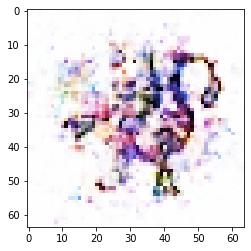

In [127]:
show_image(model.decoder(combined), model_output=True)

In [128]:
to_animate = []
for i in [2, 4, 8, 16, 32, 64, 128, 256, 512, 768, 1024, 1596, 2048]:
    if model_type == "autoencoder":
        combined = combine(output_one, output_two, mode='recombine', num_dims=i)
    else:
        combined_mu = combine(output_one_mu, output_two_mu, mode='recombine', num_dims=i)
        combined_log_var = combine(output_one_log_var, output_two_log_var, mode='recombine', num_dims=i)
        combined = model.reparameterize(combined_mu, combined_log_var)
    out = model.decoder(combined).detach().squeeze(0)
    to_animate.append(out)
anim = create_animation(to_animate)
HTML(anim.to_html5_video())